In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from nltk.corpus import stopwords
import string
from nltk.stem import SnowballStemmer, PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from textblob import Word, TextBlob
import pickle 

In [4]:
np.random.seed(3)

In [5]:
df = pd.read_csv("news.csv")
#df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


Joined the Title and the Text columns together and dropped the original title and text columns. 
Also dropped Unnamed:0 columns since it is unique for each row so will not be useful in classification

In [6]:
df['all'] = df['title'] + ' ' + df['text']
df = df.drop(['Unnamed: 0', 'title', 'text'], axis=1)

In [8]:
#remove stop words (need to be lowercase)
stop = stopwords.words('english')

df['all'] = df['all'].apply(lambda z: " ".join(z for z in z.lower().split() if z not in stop))

NRCLex is a dataset that has a list of words cateforized into different 'emotions'

In [41]:
#!pip install NRCLex
from nrclex import NRCLex
text_object = NRCLex(text = "I am a happy and excited student and a liar")
#text_object.load_raw_text(df['all'].iloc[0])

#getting to know the library's functions
print(text_object.affect_dict)
text_object.affect_list
text_object.top_emotions[0][1]
text_object.affect_frequencies

{'happy': ['anticipation', 'joy', 'positive', 'trust'], 'excited': ['anticipation', 'joy', 'positive', 'surprise', 'trust'], 'liar': ['disgust', 'negative']}


{'fear': 0.0,
 'anger': 0.0,
 'anticip': 0.0,
 'trust': 0.18181818181818182,
 'surprise': 0.09090909090909091,
 'positive': 0.18181818181818182,
 'negative': 0.09090909090909091,
 'sadness': 0.0,
 'disgust': 0.09090909090909091,
 'joy': 0.18181818181818182,
 'anticipation': 0.18181818181818182}

### Question 1: Taking into consideration the length of each text, is there a difference in the avg ratio of emotional words to total words for fake vs real news?

In [43]:
#del dfFake
dfFake = df[df['label']=='FAKE']
dfFake = dfFake.reset_index(drop=True)

c=0;
for row in dfFake['all']:
    txt_obj = NRCLex(text = row)
    x = txt_obj.top_emotions[0][0]
    y = len(txt_obj.words)            #gets total lenght of row
    d = txt_obj.raw_emotion_scores    #prints the frequency of words found in row for each 'emotion' category
    z = sum(d.values())               #sums the total number of emotional words

    #print(x)
    dfFake.loc[c, 'top_emotions'] = x 
    dfFake.loc[c, 'num_words_in_text'] = y
    dfFake.loc[c, 'sum_emotional_wrds'] = z    
    c+=1

In [45]:
dfFake['ratio_emotional_to_total'] = (dfFake['sum_emotional_wrds']/dfFake['num_words_in_text']).round(4)
avg_fake = dfFake['ratio_emotional_to_total'].mean()
print(avg_fake)

0.38113211125158014


In [46]:
dfFake

,label,all,top_emotions,num_words_in_text,sum_emotional_wrds,ratio_emotional_to_total
0,FAKE,"smell hillari fear daniel greenfield, shillman...",negative,718.0,308.0,0.4290
1,FAKE,watch exact moment paul ryan commit polit suic...,positive,271.0,91.0,0.3358
2,FAKE,berni support twitter erupt anger dnc: we tri ...,trust,278.0,124.0,0.4460
3,FAKE,"tehran, usa i'm immigrant, grandpar are. 50 ye...",positive,1284.0,607.0,0.4727
4,FAKE,girl horrifi watch boyfriend left facetim shar...,fear,312.0,103.0,0.3301
...,...,...,...,...,...,...
3159,FAKE,doj complaint: comey fire partisan witch hunt ...,trust,313.0,85.0,0.2716
3160,FAKE,radio derb air–leonardo brazil miss bum bum pa...,negative,9.0,7.0,0.7778
3161,FAKE,assang claim craze clinton campaign tri hack w...,trust,257.0,72.0,0.2802
3162,FAKE,p pbs stand plutocrat pentagon p pbs stand plu...,positive,1493.0,578.0,0.3871


In [47]:
# for the REAL classified texts in x_train, how many had negative as the top emotion?
#del dfReal
dfReal = df[df['label']=='REAL']
dfReal = dfReal.reset_index(drop=True)

c=0;
for row in dfReal['all']:
    txt_obj = NRCLex(text = row)
    x = txt_obj.top_emotions[0][0]
    y = len(txt_obj.words)
    d = txt_obj.raw_emotion_scores
    z = sum(d.values())

    #print(x)
    dfReal.loc[c, 'top_emotions'] = x 
    dfReal.loc[c, 'num_words_in_text'] = y
    dfReal.loc[c, 'sum_emotional_wrds'] = z    
    c+=1

In [48]:
dfReal['ratio_emotional_to_total'] = dfReal['sum_emotional_wrds']/dfReal['num_words_in_text']
avg_real = dfReal['ratio_emotional_to_total'].mean()
print(avg_real)

0.3874049964485361


In [49]:
dfReal

,label,all,top_emotions,num_words_in_text,sum_emotional_wrds,ratio_emotional_to_total
0,REAL,kerri go pari gestur sympathi u.s. secretari s...,positive,260.0,96.0,0.369231
1,REAL,battl new york: primari matter primari day new...,positive,201.0,90.0,0.447761
2,REAL,britain schindler die 106 czech stockbrok save...,fear,83.0,15.0,0.180723
3,REAL,fact check: trump clinton commander-in-chief f...,positive,1526.0,503.0,0.329620
4,REAL,iran report make new push uranium concess nucl...,positive,434.0,129.0,0.297235
...,...,...,...,...,...,...
3166,REAL,alabama lawmaker: same-sex coupl don't deserv ...,trust,199.0,48.0,0.241206
3167,REAL,gop senat david perdu joke pray obama death fr...,positive,243.0,119.0,0.489712
3168,REAL,state depart say can't find email clinton spec...,anticipation,402.0,127.0,0.315920
3169,REAL,"ethiopia, obama seek progress peace, secur eas...",positive,736.0,258.0,0.350543


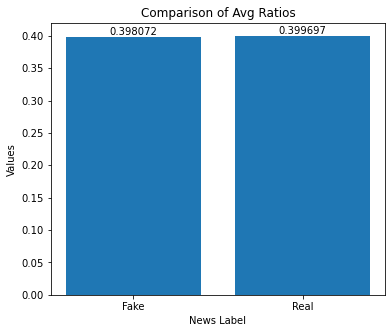

In [14]:
# Category labels (optional)
categories = ["Fake", "Real"]

# Create the bar chart
plt.figure(figsize=(6, 5))  
plt.bar(categories, [avg_fake, avg_real])

# Set chart title and labels
plt.title("Comparison of Avg Ratios")
plt.xlabel("News Label")
plt.ylabel("Values")

# Add data labels (optional)
plt.bar_label(plt.gca().containers[0])  # Get containers and add labels

# Display the chart
plt.show()

### Question 2: Is there a trend between the type of emotions found in of the Fake news vs those found in Real news?

In [15]:
dfFake2= pd.DataFrame(dfFake.groupby(['top_emotions'])['all'].count())
dfReal2= pd.DataFrame(dfReal.groupby(['top_emotions'])['all'].count())

df_joined = pd.concat([dfFake2, dfReal2], axis=1)  # Join along rows
df_joined.columns = ['Fake', 'Real']
df_joined

,Fake,Real
top_emotions,,
anger,19,16
anticipation,50,6
fear,180,131
negative,595,359
positive,1980,2321
sadness,2,2
surprise,39,31
trust,299,305


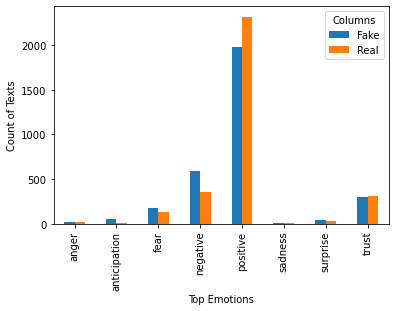

In [16]:
# Create the double bar chart
df_joined.plot(kind='bar', stacked=False)  

# Customize the chart (optional)
plt.xlabel("Top Emotions")
plt.ylabel("Count of Texts")
plt.legend(title="Columns")  

# Display the chart
plt.show()

### Conclusion: The answer to both of the questions above is NO. There is no apparent relation between the usage of 'emotional' / 'charged' words and whether the news is Fake or Real

In [17]:
#stemming 
snowstem = SnowballStemmer(language='english')
df['all'] = df['all'].apply(lambda z: " ".join([snowstem.stem(word) for word in z.split()]))

df.head()

,label,all
0,FAKE,"smell hillari fear daniel greenfield, shillman..."
1,FAKE,watch exact moment paul ryan commit polit suic...
2,REAL,kerri go pari gestur sympathi u.s. secretari s...
3,FAKE,berni support twitter erupt anger dnc: we tri ...
4,REAL,battl new york: primari matter primari day new...


In [18]:
#lemmatization
#df['text'] =df['text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#df.head()

In [19]:
x_train, x_test, y_train, y_test = train_test_split(df['all'], df['label'], test_size=0.3, shuffle=True, random_state=24)

In [26]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_test

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [27]:
#to prevent data leakage, tfidf is performed separately on training and testing datasets
tfidf_vect = TfidfVectorizer()
xtrain_tfidf = tfidf_vect.fit_transform(x_train)
xtest_tfidf =  tfidf_vect.transform(x_test)

#xtest_tfidf.data

array([0.02143249, 0.01756081, 0.03512161, ..., 0.03122463, 0.03439567,
       0.01447656])

#### Classification Model 1: Passive Aggressive Classifier

In [28]:
pac=PassiveAggressiveClassifier()
pac.fit(xtrain_tfidf, y_train)

y_pred=pac.predict(xtest_tfidf)

from sklearn import metrics
pac_acc = metrics.accuracy_score(y_pred, y_test).round(5)*100
pac_acc

93.161

#### Classification Model 2: Naive Bayes Classifier

In [51]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(xtrain_tfidf.toarray(), y_train)
   
y_pred = gnb.predict(xtest_tfidf.toarray())
   
nb_acc = metrics.accuracy_score(y_test, y_pred)*100
nb_acc = nb_acc.round(5)
nb_acc

#### Classification Model 3: Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

RFclf = RandomForestClassifier(max_depth=4)#, random_state=0)
RFclf.fit(xtrain_tfidf, y_train)
y_pred = RFclf.predict(xtest_tfidf)

rf_acc = metrics.accuracy_score(y_test, y_pred).round(5)*100
rf_acc

80.589

#### Classification Model 4: Support Vector Classifier

In [31]:
from sklearn.svm import SVC
SVCclf = SVC(kernel='linear')

SVCclf.fit(xtrain_tfidf, y_train)

y_pred = SVCclf.predict(xtest_tfidf)
svc_acc = metrics.accuracy_score(y_test, y_pred).round(5)*100
svc_acc

92.898

### Visualization of Results

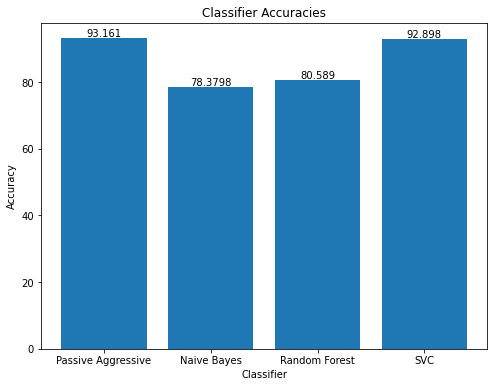

In [32]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.bar(['Passive Aggressive', 'Naive Bayes', 'Random Forest', 'SVC'], [pac_acc, nb_acc, rf_acc, svc_acc])
plt.title('Classifier Accuracies')
plt.xlabel("Classifier")
plt.ylabel("Accuracy")

plt.bar_label(plt.gca().containers[0])  # Get containers and add labels

plt.show;

### Saving the Models Used

In [57]:
with open('preprocessing.pkl', 'wb') as f:
    pickle.dump((tfidf_vect), f)

with open('models.pkl', 'wb') as f:
    pickle.dump((pac), f)